In [1]:
# Exercise 7-10

In [2]:
# Packages
rm(list=ls())
library(ISLR)  # College dset
library(leaps) # Reg subsets functions
library(gam)   # gam function

Loading required package: splines

Loading required package: foreach

Loaded gam 1.16




In [3]:
# Data
attach(College)
fix(College)
summary(College)

 Private        Apps           Accept          Enroll       Top10perc    
 No :212   Min.   :   81   Min.   :   72   Min.   :  35   Min.   : 1.00  
 Yes:565   1st Qu.:  776   1st Qu.:  604   1st Qu.: 242   1st Qu.:15.00  
           Median : 1558   Median : 1110   Median : 434   Median :23.00  
           Mean   : 3002   Mean   : 2019   Mean   : 780   Mean   :27.56  
           3rd Qu.: 3624   3rd Qu.: 2424   3rd Qu.: 902   3rd Qu.:35.00  
           Max.   :48094   Max.   :26330   Max.   :6392   Max.   :96.00  
   Top25perc      F.Undergrad     P.Undergrad         Outstate    
 Min.   :  9.0   Min.   :  139   Min.   :    1.0   Min.   : 2340  
 1st Qu.: 41.0   1st Qu.:  992   1st Qu.:   95.0   1st Qu.: 7320  
 Median : 54.0   Median : 1707   Median :  353.0   Median : 9990  
 Mean   : 55.8   Mean   : 3700   Mean   :  855.3   Mean   :10441  
 3rd Qu.: 69.0   3rd Qu.: 4005   3rd Qu.:  967.0   3rd Qu.:12925  
 Max.   :100.0   Max.   :31643   Max.   :21836.0   Max.   :21700  
   Room.Board

In [4]:
# Create train/test partition
set.seed(1)
College$ind <- ifelse(runif(n=nrow(College))>=0.7, 1, 0)
train <- College[College$ind==1,]
train <- subset(train, select=-c(ind))
test <- College[College$ind==0,]
test <- subset(test, select=-c(ind))
ncol(train); ncol(test)

[1] 18

[1] 18

In [5]:
# Use forward stepwise selection to ID model that uses just a subset of the predictors:
m1 <- regsubsets(Outstate~., data=train, method="forward", nvmax=17)
m1.summary <- summary(m1)
summary(m1)

Subset selection object
Call: regsubsets.formula(Outstate ~ ., data = train, method = "forward", 
    nvmax = 17)
17 Variables  (and intercept)
            Forced in Forced out
PrivateYes      FALSE      FALSE
Apps            FALSE      FALSE
Accept          FALSE      FALSE
Enroll          FALSE      FALSE
Top10perc       FALSE      FALSE
Top25perc       FALSE      FALSE
F.Undergrad     FALSE      FALSE
P.Undergrad     FALSE      FALSE
Room.Board      FALSE      FALSE
Books           FALSE      FALSE
Personal        FALSE      FALSE
PhD             FALSE      FALSE
Terminal        FALSE      FALSE
S.F.Ratio       FALSE      FALSE
perc.alumni     FALSE      FALSE
Expend          FALSE      FALSE
Grad.Rate       FALSE      FALSE
1 subsets of each size up to 17
Selection Algorithm: forward
          PrivateYes Apps Accept Enroll Top10perc Top25perc F.Undergrad
1  ( 1 )  " "        " "  " "    " "    " "       " "       " "        
2  ( 1 )  "*"        " "  " "    " "    " "       " "    

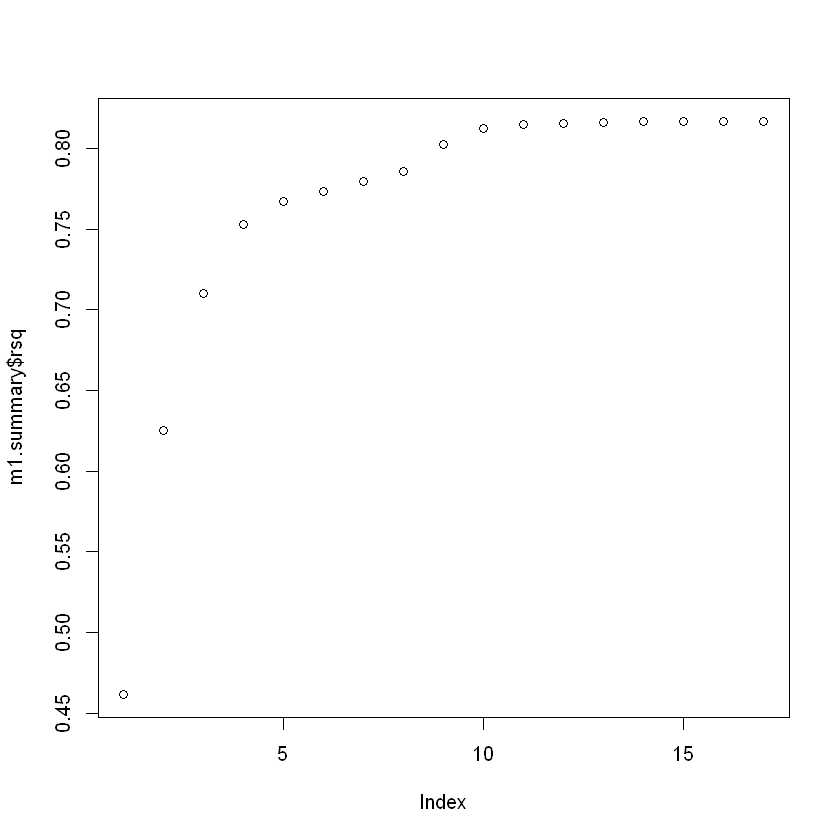

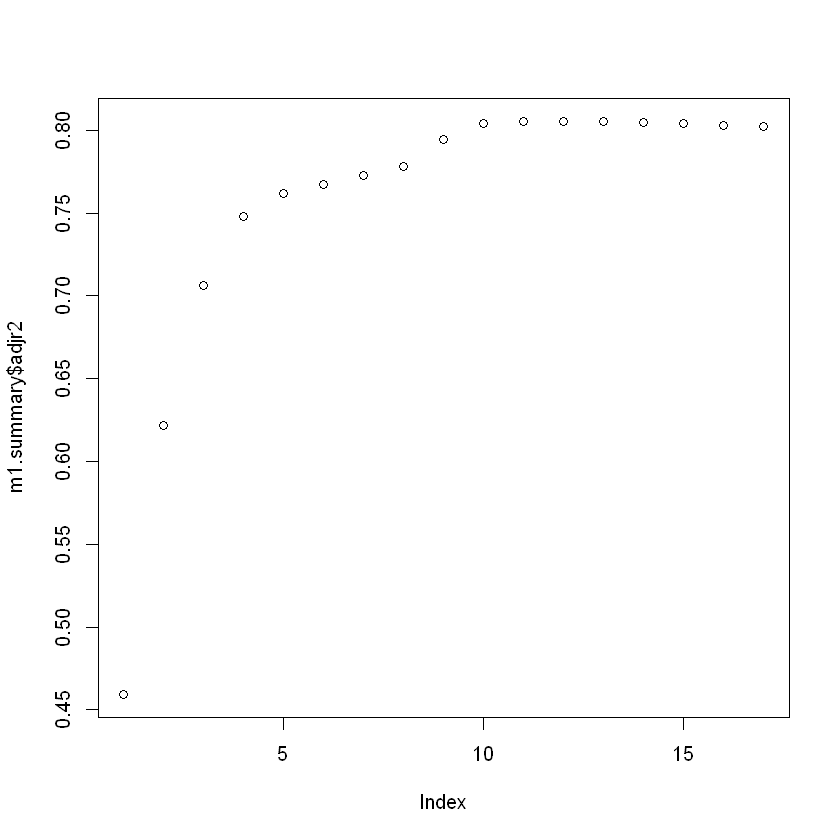

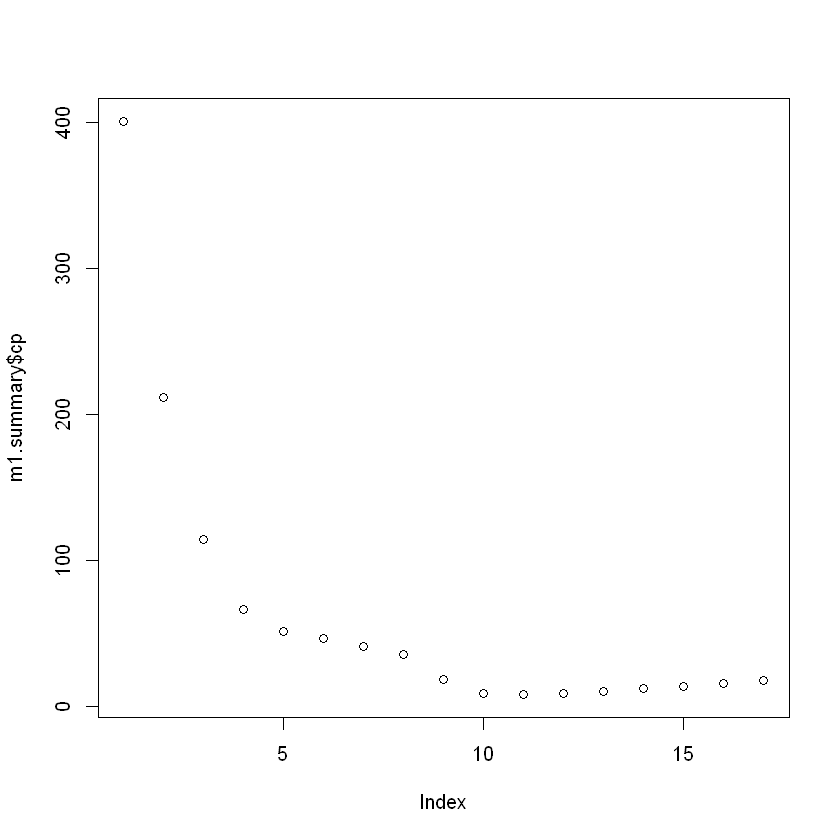

In [6]:
# Viz diagnostics:
plot(m1.summary$rsq)
plot(m1.summary$adjr2)
plot(m1.summary$cp)
# Based on the above 3 diagnostics, I identify the 5-variable model as a model that produces satisfactory performance
# using only some of the predictors.  I select it because it is roughly where the improvement starts to level off
# in all three graphs.
# 5 features = PrivateYes, Room.Board, Terminal, Expend, Grad.Rate

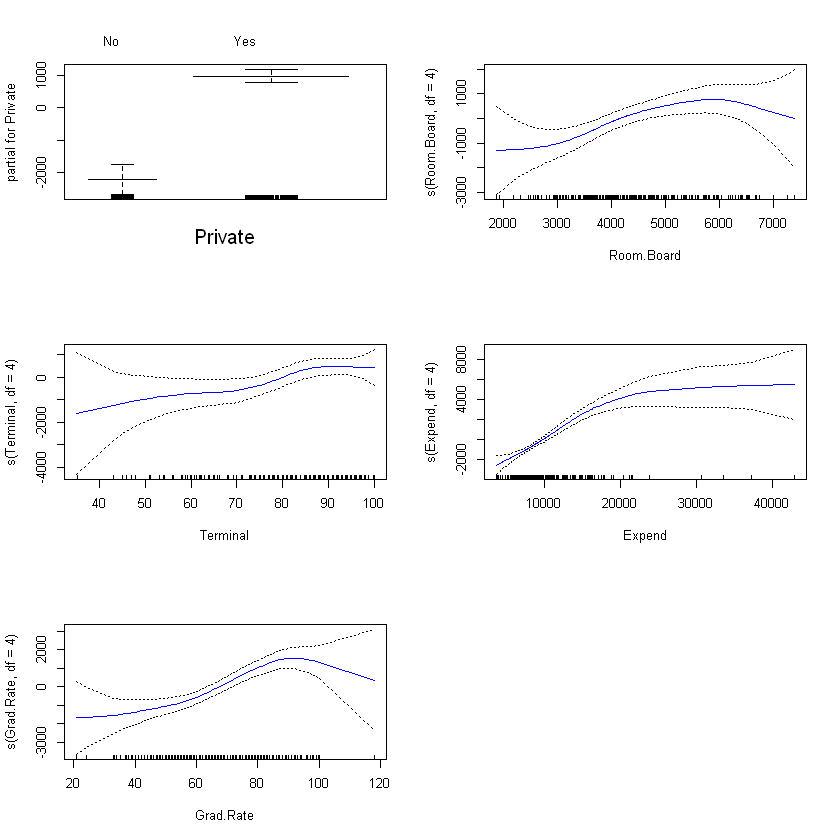

In [7]:
# Part b: Here I fit a GAM (using the above ID'd 5 vars) using smoothing splines for the variates.  For simplicity,
# I judgementally select 4 as the effective dof for each spline, and then plot:
m2 <- gam(Outstate~Private+s(Room.Board,df=4)+s(Terminal,df=4)+s(Expend,df=4)+s(Grad.Rate,df=4), data=train)
par(mfrow=c(3,2))
plot(m2, se=TRUE, col="blue")
# The fit to Terminal is somewhat linear, to Expend somewhat logarithmic, and to Room.Board and Grad.Rate are somewhat 
# quadratic.  Clearly this non-linear fit believes it sees patterns that it may model better than the above
# forward stepwise regression: the test set will tell us if this additional flexibility modelled adds value or not.

In [18]:
# Part c: here I evaluate the two above models on the test set:
# 5-var Stepwise regression model:
m1b <- lm(Outstate~Private+Room.Board+Terminal+Expend+Grad.Rate, data=train)
pred1 <- predict(m1b, newdata=test)
m1b_rmse <- sqrt(mean((pred1-test$Outstate)^2))
# 5-var GAM:
pred2 <- predict(m2, newdata=test)
m2_rmse <- sqrt(mean((pred2-test$Outstate)^2))
# RMSE reduction that GAM achieves:
print(m1b_rmse); print(m2_rmse); print(m2_rmse/m1b_rmse-1)
# Clearly the GAM achieves more than a 9% reduction in RMSE relative to the selected 5-variable regression model.
# This is likely driven by the GAM efficiently incorporating non-linearities of the data better than the linear reg model.

[1] 2130.872
[1] 1934.21
[1] -0.09229175


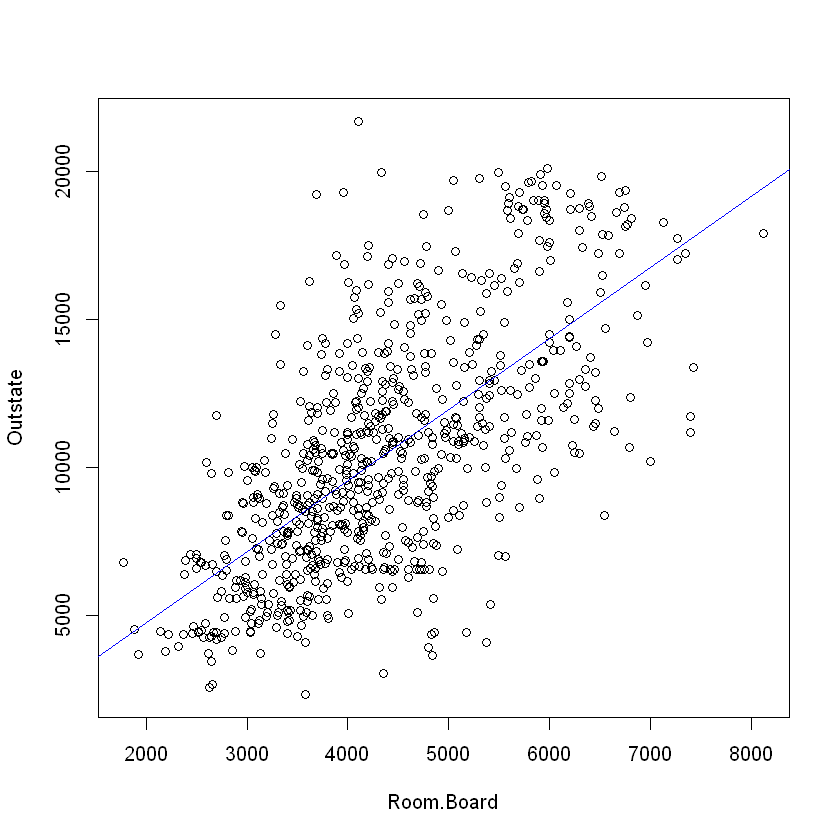

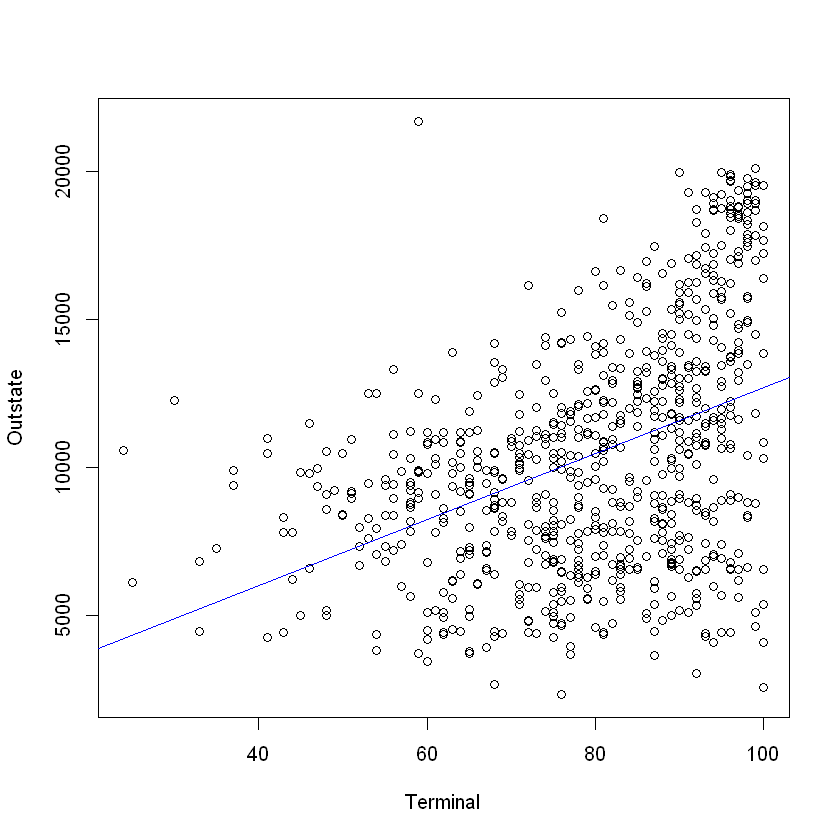

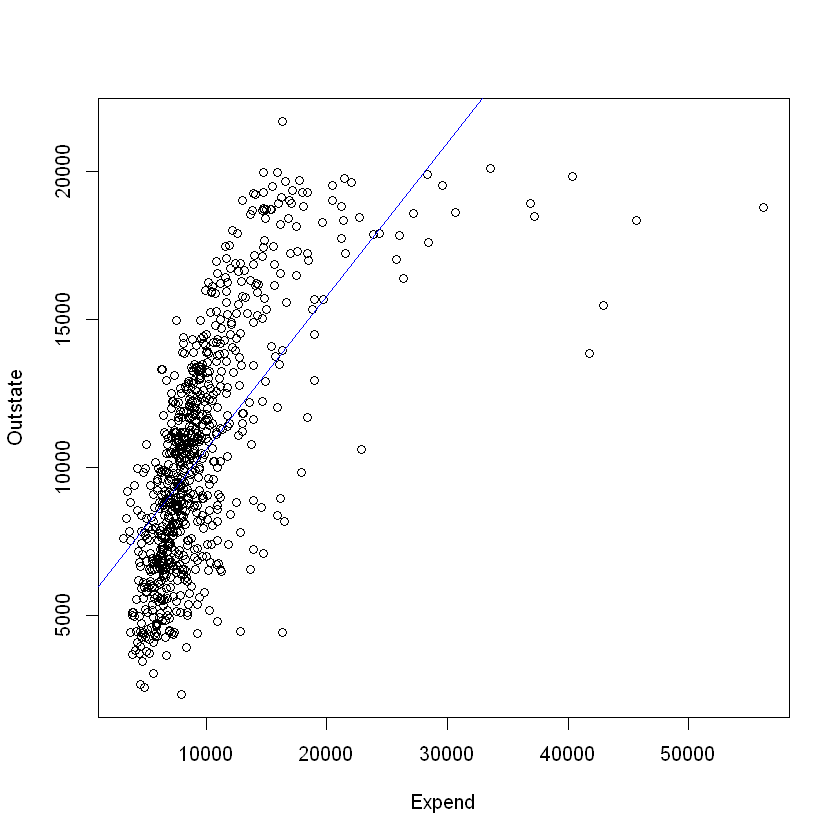

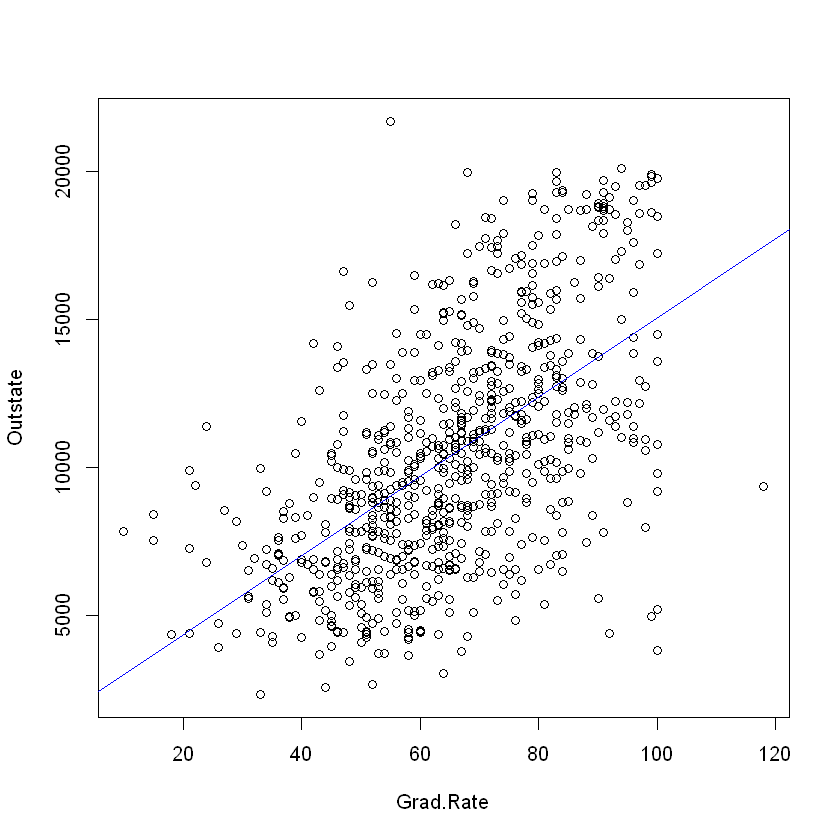

In [27]:
# Part d: for which variables (if any), is there evidence of a non-linear relationship with the response?
# As Private is a categorical variable, I will not examine that here.
plot(Room.Board, Outstate)
reg1 <- lm(Outstate~Room.Board, data=College)
abline(reg1, col="blue")
plot(Terminal, Outstate)
reg2 <- lm(Outstate~Terminal, data=College)
abline(reg2, col="blue")
plot(Expend, Outstate)
reg3 <- lm(Outstate~Expend, data=College)
abline(reg3, col="blue")
plot(Grad.Rate, Outstate)
reg4 <- lm(Outstate~Grad.Rate, data=College)
abline(reg4, col="blue")
# Supported by the below plots, I have the following observations:
# 1. The relationship between Room.Board and Outstate may display heteroskedasticity, but it does not really look non-linear.
# 2. The relationship between Terminal and Outstate displays heteroskedasticity as well and some non-linearity in the rt tail.
# 3. The relationship between Expend and Outstate displays non-linearity, as the curve looks somewhat logarithmic and starts
#       to flatten out in the tail.  Clearly the above fit that looked somewhat logarithmic was a good choice by the GAM.
# 4. The relationship between Grad.Rate and Outstate may display heteroskedasticity, but it does not really look non-linear.